# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<!-- TOC --><a name="data-analysis"></a>
# Data analysis

In [2]:
# Define data paths

test_dir = "/test"
train_dir = "/train"

In [3]:
# Check size of each dataset

import os

def get_dataset_size(dir, type):
    print(f"Scanning {type} images...")
    size = 0
    for label in os.listdir(dir):
        size += len(os.listdir(os.path.join(dir, label)))
    print(f"Number of {type} images: {size}\n")
    return size

num_test = get_dataset_size(test_dir, "test")
num_train = get_dataset_size(train_dir, "train")

Scanning test images...
Number of test images: 140

Scanning train images...
Number of train images: 557



In [4]:
num_classes = len(os.listdir(train_dir))
print(f"Number of classes: {num_classes}")

Number of classes: 2


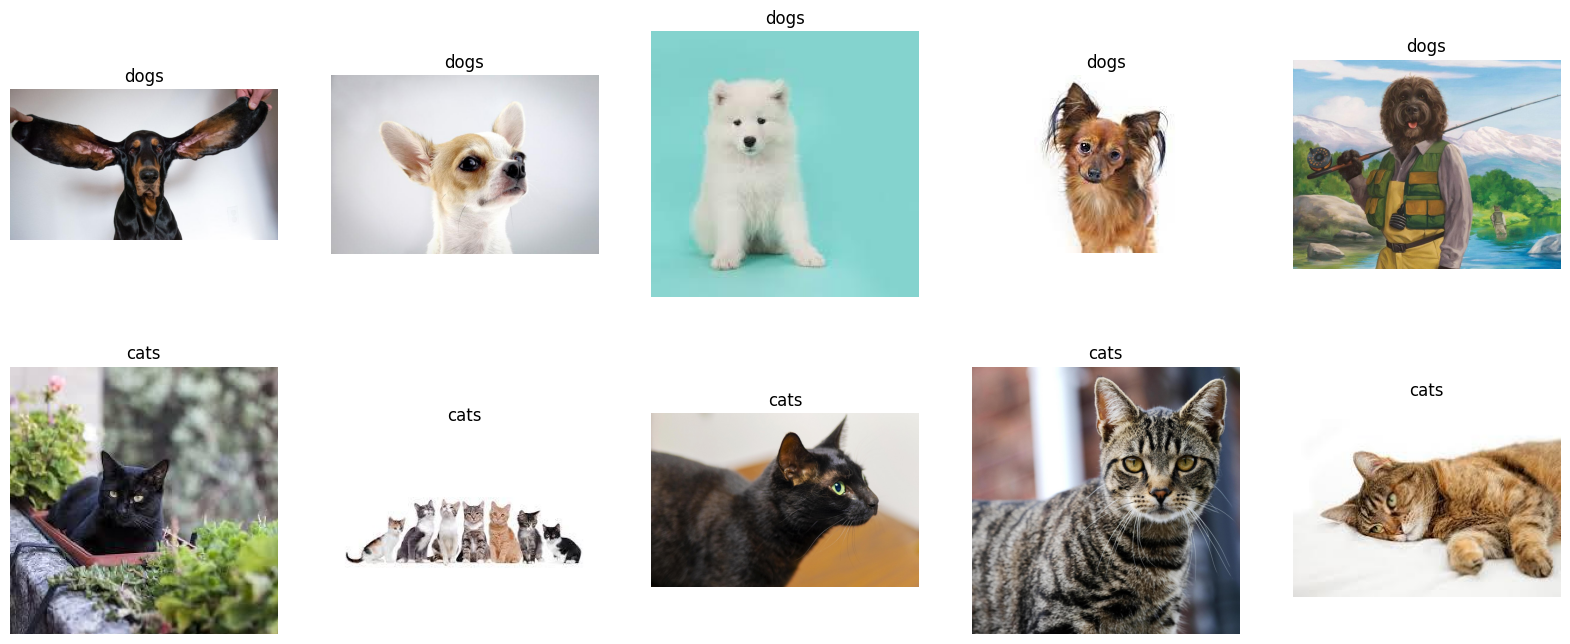

In [5]:
# Let's view a few training samples

import random
import cv2

# imgs to plot per class
m = 5

fig, axs = plt.subplots(nrows=num_classes, ncols=m, figsize=(m*4, num_classes*4))

for i in range(num_classes):

    label = os.listdir(train_dir)[i]
    
    for j in range(m):
        
        # get a random image from the chosen species
        
        img_name = random.choice(os.listdir(os.path.join(train_dir, label)))
        img_path = os.path.join(train_dir, label, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # plot the image
        axs[i][j].imshow(image)
        axs[i][j].set_title(label)
        axs[i][j].axis("off")
        
fig.show()

<!-- TOC --><a name="create-image-data-generators"></a>
# Create image data generators

In [6]:
# Let's create our image preprocessors

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    validation_split=0.1
)

In [7]:
# Let's define the target size

input_size = (224, 224)

In [8]:
# Let's create our image generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=True,
    subset="training"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=32,
    shuffle=False,
    subset="validation"
)

Found 557 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


<!-- TOC --><a name="set-up-the-model"></a>
# Set up the model

<!-- TOC --><a name="load-pretrained-model"></a>
## Load pretrained model

Let's load a Resnet50 model which has been pretrained on the ImageNet dataset

In [9]:
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

base_model = VGG19(
    include_top = False,
    weights="imagenet",
)

80134624/80134624 [==============================] - 0s 0us/step


In [10]:
# Let's print out a description of the model layers

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [11]:
len(base_model.trainable_variables)

32

<!-- TOC --><a name="create-classification-model"></a>
## Create classification model

Let's add a classification head to this pretrained model

In [12]:
# Before we add the classification head,
# Let's get the output shape of the ResNet (without the classification head)

image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(f"Output shape of feature extractor: {feature_batch.shape}")

Output shape of feature extractor: (32, 7, 7, 512)


In [13]:
# Let's freeze the feature extractor

base_model.trainable = False

In [14]:
# Add a global pooling layer to flatten the output of the feature extractor

from tensorflow.keras.layers import GlobalAveragePooling2D

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [15]:
# Add a fully connected layer

from tensorflow.keras.layers import Dense

prediction_layer = Dense(num_classes)
prediction_layer_output = prediction_layer(feature_batch_average)
print(prediction_layer_output.shape)

(32, 2)


In [16]:
# Now let's combine all the layers into a complete model

inputs = tf.keras.Input(shape=input_size + (3,))
x = preprocess_input(inputs)
x = base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [17]:
# Let's explore the model's layers

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026  

In [18]:
len(model.trainable_variables)

2

<!-- TOC --><a name="training"></a>
# Training

<!-- TOC --><a name="training-the-classification-model"></a>
## Training the classification model

In [19]:
# Let's compile the model


base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
initial_epochs = 50

In [21]:
loss0, accuracy0 = model.evaluate(val_generator)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 13s 2s/step - loss: 5.3864 - accuracy: 0.5079
initial loss: 5.39
initial accuracy: 0.51


In [22]:
# Let's fit the model
# Remember, we are only training the classification head

history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=val_generator
)

Epoch 1/50
18/18 [==============================] - 11s 515ms/step - loss: 3.8449 - accuracy: 0.4991 - val_loss: 4.5109 - val_accuracy: 0.5238
Epoch 2/50
18/18 [==============================] - 5s 257ms/step - loss: 3.2140 - accuracy: 0.4937 - val_loss: 3.7360 - val_accuracy: 0.5238
Epoch 3/50
18/18 [==============================] - 5s 277ms/step - loss: 2.8968 - accuracy: 0.4937 - val_loss: 3.2440 - val_accuracy: 0.5238
Epoch 4/50
18/18 [==============================] - 5s 266ms/step - loss: 2.7518 - accuracy: 0.5117 - val_loss: 2.9327 - val_accuracy: 0.5397
Epoch 5/50
18/18 [==============================] - 5s 264ms/step - loss: 2.4967 - accuracy: 0.4973 - val_loss: 2.8090 - val_accuracy: 0.5476
Epoch 6/50
18/18 [==============================] - 5s 271ms/step - loss: 2.4465 - accuracy: 0.5135 - val_loss: 2.5964 - val_accuracy: 0.5556
Epoch 7/50
18/18 [==============================] - 5s 272ms/step - loss: 2.3666 - accuracy: 0.5206 - val_loss: 2.3351 - val_accuracy: 0.5635
Epoch

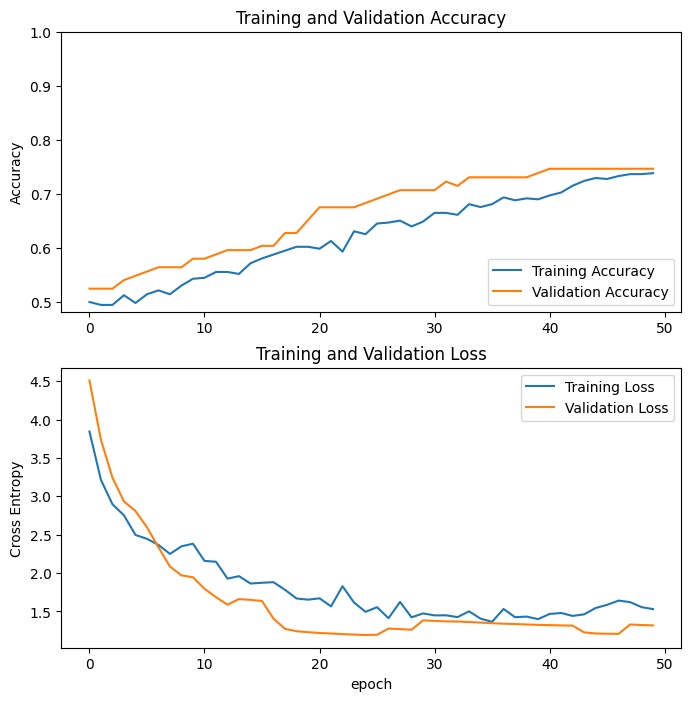

In [23]:
# Let's plot the results of the training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<!-- TOC --><a name="fine-tuning"></a>
## Fine-tuning

Now that we've trained the classification head, let's train some of the top layers to greatly improve the performance of the model.

In [24]:
base_model.trainable = True

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  22


In [26]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 1026  

In [28]:
len(model.trainable_variables)

8

In [29]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

In [30]:
# Let's fine tune the model

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=[earlystopping]
)

Epoch 50/100
18/18 [==============================] - 8s 316ms/step - loss: 0.8486 - accuracy: 0.8510 - val_loss: 0.4111 - val_accuracy: 0.9048
Epoch 51/100
18/18 [==============================] - 5s 273ms/step - loss: 0.2286 - accuracy: 0.9425 - val_loss: 0.3084 - val_accuracy: 0.9365
Epoch 52/100
18/18 [==============================] - 5s 299ms/step - loss: 0.0925 - accuracy: 0.9856 - val_loss: 0.2653 - val_accuracy: 0.9286
Epoch 53/100
18/18 [==============================] - 5s 277ms/step - loss: 0.0507 - accuracy: 0.9928 - val_loss: 0.2595 - val_accuracy: 0.9524
Epoch 54/100
18/18 [==============================] - 5s 279ms/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.2401 - val_accuracy: 0.9524
Epoch 55/100
18/18 [==============================] - 5s 272ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.9524
Epoch 56/100
18/18 [==============================] - 5s 264ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.2255 - val_accuracy:

Wow! That really boosted performance!

In [31]:
# Update the accuracy and loss

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

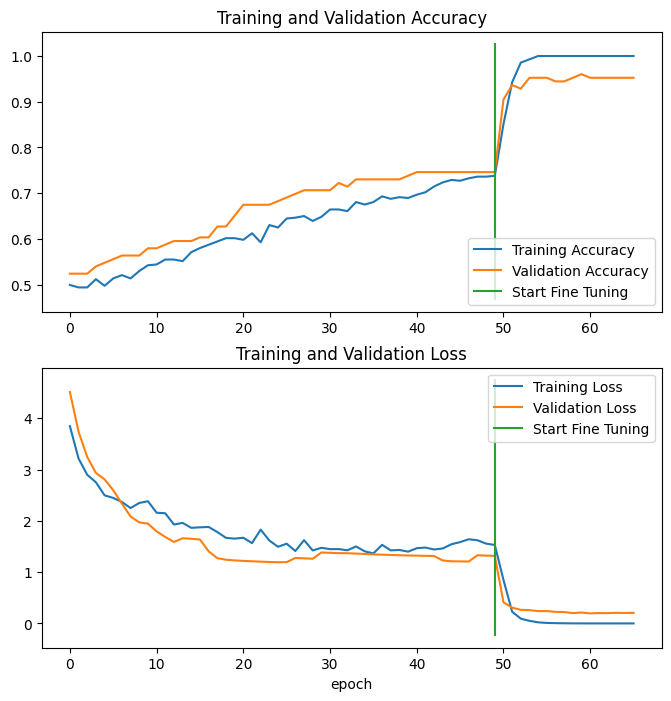

In [32]:
# Plot the results!

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<!-- TOC --><a name="evaluate-the-final-model"></a>
# Evaluate the final model

In [33]:
loss, acc = model.evaluate(test_generator, verbose=False)
print(f"Validation accuracy: {acc*100}%")

Validation accuracy: 92.85714030265808%
